CODE BLOCK: 1

In [1]:
import torch  # PyTorch library for deep learning
import torch.nn as nn  # Module to create neural network layers
import torch.nn.functional as F  # Functional interface containing typical operations used for building neural networks like activation functions
import torch.optim as optim  # Optimizers for training neural networks
from torchsummary import summary
from torchvision import datasets, transforms  # Datasets and transformations utilities from torchvision

from  utils import ModelTrainer
from model import Net


c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()  # Check if CUDA (GPU support) is available
device = torch.device("cuda" if cuda else "cpu")  # Select GPU if available, otherwise fall back to CPU
print("CUDA Available?", cuda) # Is it available
device # Display the selected device

CUDA Available? False


device(type='cpu')

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)), # Resize image at (28,28)
    transforms.RandomRotation((-15., 15.), fill=0), # Rotate the image by angle.
    transforms.ToTensor(),# Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,)), # Normalize images
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize images
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) # Loading and Downloading the MNIST training dataset
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms) ## Loading and Downloading the MNIST testing dataset.By setting train=False, you correctly specify that you want to load the MNIST test dataset.

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomApply(
               p=0.1
               CenterCrop(size=(22, 22))
           )
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [7]:
batch_size = 512 # Setting the batch size for training and testing

# Define keyword arguments for DataLoader instances.
# 'batch_size' specifies how many samples per batch to load.
# 'shuffle': False means that the data will not be shuffled before being loaded (common for test data).
# 'num_workers': 2 indicates the number of subprocesses to use for data loading which can accelerate the data loading process.
# 'pin_memory': True suggests that DataLoader will try to pin memory during data loading, which can speed up data transfer to CUDA-enabled GPUs.
kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

# Create a DataLoader for the test dataset. Although it's named `test_loader`, it's incorrectly using `train_data`.
# Typically, you would use a separate dataset for testing to evaluate the model's performance on unseen data.
# The DataLoader loads the data with the specified batch size and other parameters defined in `kwargs`.
# Since `shuffle` is False, the data will be loaded in the same order every time, which is typical for testing.
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

# Create a DataLoader for the training dataset from the same `train_data`.
# Even though `shuffle` is set to False as per `kwargs`, for training, you might want to set 'shuffle': True
# to ensure that the model does not learn the order of the data, helping it to generalize better.
# This DataLoader also loads the data with the specified batch size and other parameters defined in `kwargs`.
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [8]:
test_loader

In [9]:
train_loader

CODE BLOCK: 6

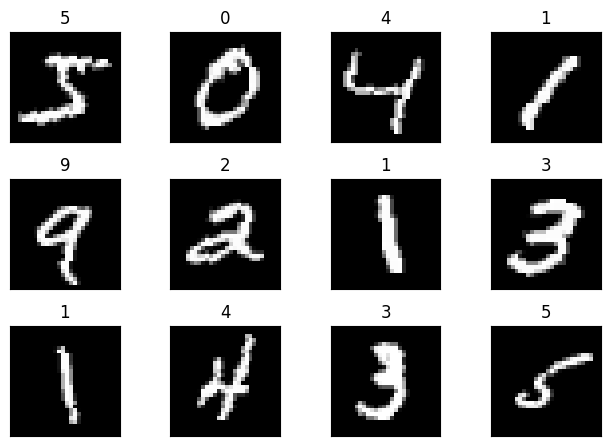

In [10]:
# Import the matplotlib library for plotting
import matplotlib.pyplot as plt

# Retrieve a single batch of data from the train_loader
batch_data, batch_label = next(iter(train_loader))

# Initialize a figure for plotting
fig = plt.figure()

# Loop over the first 12 images and labels in the batch to create subplots
for i in range(12):
  # Create a subplot with 4 rows and 3 columns for each image
  plt.subplot(3,4,i+1)
  # Adjust the layout to prevent overlapping
  plt.tight_layout()
  # Display an image. Use .squeeze(0) to remove the channel dimension for grayscale visualization
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  # Set the title of each subplot to the corresponding label of the image
  plt.title(batch_label[i].item())
  # Remove the x-ticks as they are unnecessary for image visualization
  plt.xticks([])
  # Remove the y-ticks as they are unnecessary for image visualization
  plt.yticks([])

CODE BLOCK: 7

In [11]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 5


trainer = ModelTrainer()



for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  trainer.train_model(model, device, train_loader, optimizer, criterion)
  trainer.test_model(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.1662 Batch_id=117 Accuracy=26.38: 100%|██████████| 118/118 [00:12<00:00,  9.45it/s]


Test set: Average loss: 0.0042, Accuracy: 5250/10000 (52.50%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.3578 Batch_id=117 Accuracy=79.07: 100%|██████████| 118/118 [00:13<00:00,  8.83it/s]


Test set: Average loss: 0.0003, Accuracy: 9602/10000 (96.02%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2464 Batch_id=117 Accuracy=95.05: 100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Test set: Average loss: 0.0002, Accuracy: 9754/10000 (97.54%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2073 Batch_id=117 Accuracy=96.33: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Test set: Average loss: 0.0001, Accuracy: 9799/10000 (97.99%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1959 Batch_id=117 Accuracy=97.10: 100%|██████████| 118/118 [00:13<00:00,  8.73it/s]


Test set: Average loss: 0.0001, Accuracy: 9839/10000 (98.39%)
Adjusting learning rate of group 0 to 1.0000e-02.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

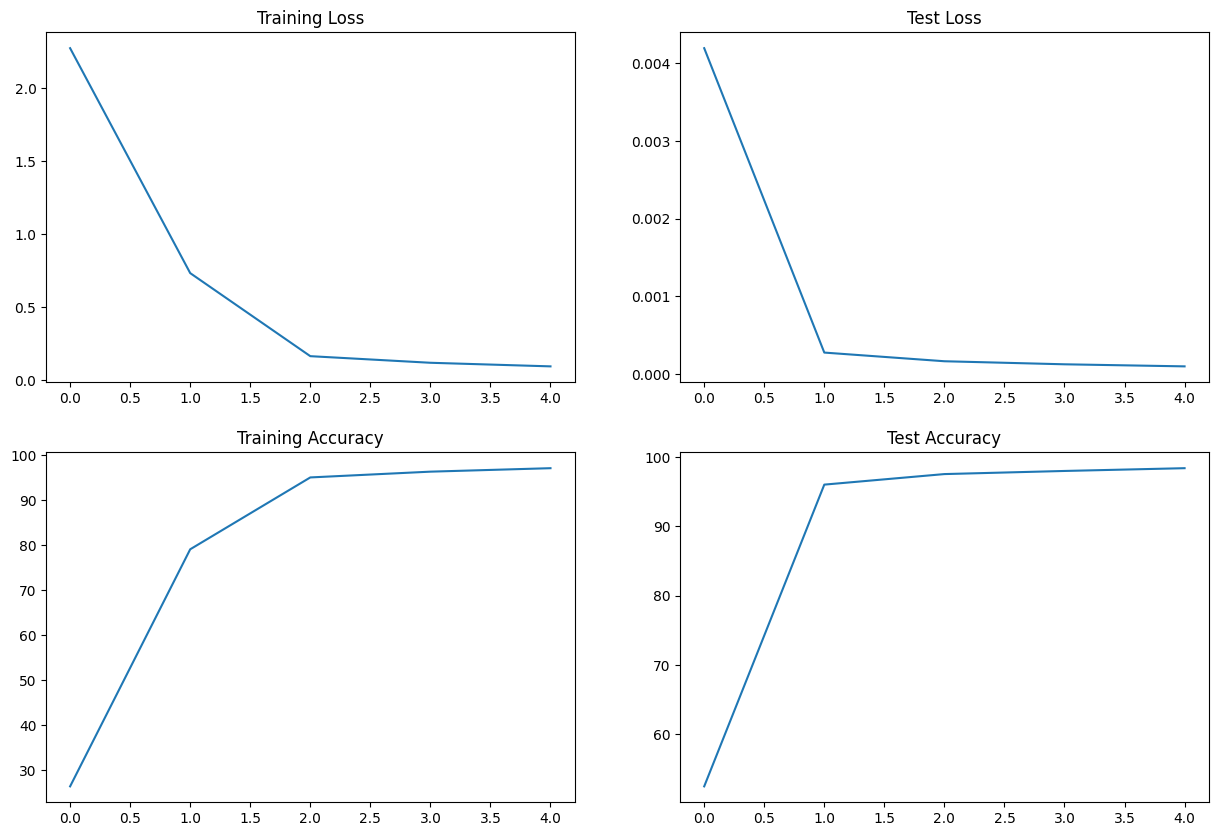

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(trainer.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(trainer.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(trainer.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(trainer.test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
gamma_values = [0.1, 0.2, 0.3]
num_epochs = 5

for gamma in gamma_values:
    # Reset model and optimizer here if needed
    # model = Net().to(device)
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=gamma, verbose=True)
    print(f"Training with gamma={gamma}")
    trainer = ModelTrainer()
    trainer.run_training_cycle(model, device, train_loader, test_loader, optimizer, criterion, scheduler, num_epochs)

    # Display the results for this gamma value
    # You can plot results or print out statistics here
    # For example:
    print(f"Results for gamma={gamma}:")
    print(f"Train Accuracy: {trainer.train_acc}")
    print(f"Test Accuracy: {trainer.test_acc}")

Adjusting learning rate of group 0 to 1.0000e-02.
Training with gamma=0.1
Epoch 1


Train: Loss=0.6270 Batch_id=117 Accuracy=35.04: 100%|██████████| 118/118 [00:12<00:00,  9.65it/s]


Test set: Average loss: 0.0010, Accuracy: 8356/10000 (83.56%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.3715 Batch_id=117 Accuracy=90.73: 100%|██████████| 118/118 [00:12<00:00,  9.72it/s]


Test set: Average loss: 0.0002, Accuracy: 9614/10000 (96.14%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2839 Batch_id=117 Accuracy=95.48: 100%|██████████| 118/118 [00:12<00:00,  9.74it/s]


Test set: Average loss: 0.0002, Accuracy: 9764/10000 (97.64%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2692 Batch_id=117 Accuracy=96.52: 100%|██████████| 118/118 [00:12<00:00,  9.67it/s]


Test set: Average loss: 0.0001, Accuracy: 9784/10000 (97.84%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.2163 Batch_id=117 Accuracy=97.17: 100%|██████████| 118/118 [00:12<00:00,  9.69it/s]


Test set: Average loss: 0.0001, Accuracy: 9842/10000 (98.42%)
Adjusting learning rate of group 0 to 1.0000e-02.
Results for gamma=0.1:
Train Accuracy: [35.04, 90.72666666666667, 95.48, 96.51833333333333, 97.175]
Test Accuracy: [83.56, 96.14, 97.64, 97.84, 98.42]
Adjusting learning rate of group 0 to 1.0000e-02.
Training with gamma=0.2
Epoch 1


Train: Loss=0.2200 Batch_id=117 Accuracy=97.50: 100%|██████████| 118/118 [00:12<00:00,  9.66it/s]


Test set: Average loss: 0.0001, Accuracy: 9848/10000 (98.48%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2103 Batch_id=117 Accuracy=97.85: 100%|██████████| 118/118 [00:12<00:00,  9.68it/s]


Test set: Average loss: 0.0001, Accuracy: 9865/10000 (98.65%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1746 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:12<00:00,  9.80it/s]


Test set: Average loss: 0.0001, Accuracy: 9863/10000 (98.63%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1600 Batch_id=117 Accuracy=98.10: 100%|██████████| 118/118 [00:12<00:00,  9.66it/s]


Test set: Average loss: 0.0001, Accuracy: 9877/10000 (98.77%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1754 Batch_id=117 Accuracy=98.22: 100%|██████████| 118/118 [00:12<00:00,  9.76it/s]


Test set: Average loss: 0.0001, Accuracy: 9878/10000 (98.78%)
Adjusting learning rate of group 0 to 1.0000e-02.
Results for gamma=0.2:
Train Accuracy: [97.495, 97.85166666666667, 97.945, 98.10166666666667, 98.22]
Test Accuracy: [98.48, 98.65, 98.63, 98.77, 98.78]
Adjusting learning rate of group 0 to 1.0000e-02.
Training with gamma=0.3
Epoch 1


Train: Loss=0.1340 Batch_id=117 Accuracy=98.33: 100%|██████████| 118/118 [00:12<00:00,  9.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9896/10000 (98.96%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1768 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:12<00:00,  9.70it/s]


Test set: Average loss: 0.0001, Accuracy: 9900/10000 (99.00%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1438 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:12<00:00,  9.64it/s]


Test set: Average loss: 0.0001, Accuracy: 9906/10000 (99.06%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1262 Batch_id=117 Accuracy=98.70: 100%|██████████| 118/118 [00:12<00:00,  9.65it/s]


Test set: Average loss: 0.0001, Accuracy: 9906/10000 (99.06%)
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1353 Batch_id=117 Accuracy=98.71: 100%|██████████| 118/118 [00:12<00:00,  9.61it/s]


Test set: Average loss: 0.0001, Accuracy: 9914/10000 (99.14%)
Adjusting learning rate of group 0 to 1.0000e-02.
Results for gamma=0.3:
Train Accuracy: [98.33333333333333, 98.565, 98.6, 98.69833333333334, 98.71333333333334]
Test Accuracy: [98.96, 99.0, 99.06, 99.06, 99.14]
